In [5]:
import numpy as np
import pandas as pd
import re
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [6]:
# Membaca file CSV
df = pd.read_csv('datacoba - dataset_resa_hiv_retrieval2.csv')

# Menampilkan beberapa baris pertama untuk memastikan data terbaca dengan benar
print(df.head())

# Mengambil kolom yang relevan
my_df = df[['Desease', 'Diagnosa', 'Link']]

# Preprocessing: konversi teks menjadi lowercase
my_df = my_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Preprocessing: hapus karakter yang tidak diinginkan pada kolom 'Diagnosa'
my_df['Diagnosa'] = my_df['Diagnosa'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Tokenisasi teks pada kolom 'Diagnosa' menggunakan Keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
my_df['cleaned_text'] = my_df['Diagnosa'].apply(lambda x: text_to_word_sequence(x))


  Desease      Kode                                           Diagnosa  \
0     HIV  39134398  Sexually transmitted infections and migration ...   
1     HIV  39134343  Long-term retention and positive deviant pract...   
2     HIV  39134039  Childhood sexual trauma and opioid use among o...   
3     HIV  39134019  HIV-1 resistance and virological failure to tr...   
4     HIV  39135151  Immune signature in vaccinated versus non-vacc...   

                                        Link  
0  https://pubmed.ncbi.nlm.nih.gov/39134398/  
1  https://pubmed.ncbi.nlm.nih.gov/39134343/  
2  https://pubmed.ncbi.nlm.nih.gov/39134039/  
3  https://pubmed.ncbi.nlm.nih.gov/39134019/  
4  https://pubmed.ncbi.nlm.nih.gov/39135151/  


In [7]:
from gensim.models import Word2Vec

# Data preprocessing - sepertinya ini sudah kamu lakukan di kode sebelumnya
sentences = my_df['cleaned_text'].tolist()  # Daftar kalimat dari teks yang sudah dipreproses

# Membuat model Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


In [8]:
# Membuat embedding matrix dari Word2Vec
vocab_size = len(word2vec_model.wv.index_to_key) + 1
embedding_matrix = np.zeros((vocab_size, 100))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(my_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(my_df['cleaned_text'])
padded_sequences = pad_sequences(sequences, padding='post')

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [9]:
# Split data menjadi training dan validation
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, np.random.randint(2, size=len(my_df)), test_size=0.2, random_state=42)

In [10]:
# Definisikan model Sequential
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=padded_sequences.shape[1], trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
# Compiling model dengan optimizer Adam dan learning rate yang disesuaikan
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping untuk menghindari overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model dengan early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4920 - loss: 0.6961 - val_accuracy: 0.4333 - val_loss: 0.6970
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5633 - loss: 0.6925 - val_accuracy: 0.4333 - val_loss: 0.7052
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5477 - loss: 0.6907 - val_accuracy: 0.4333 - val_loss: 0.7038
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5467 - loss: 0.6886 - val_accuracy: 0.4333 - val_loss: 0.7039
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5198 - loss: 0.6938 - val_accuracy: 0.4333 - val_loss: 0.7070
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5195 - loss: 0.6936 - val_accuracy: 0.4333 - val_loss: 0.7087


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4347 - loss: 0.6970 
Loss: 0.6970272064208984, Accuracy: 0.4333333373069763
Accuracy: 43.33%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.43      1.00      0.60        26

    accuracy                           0.43        60
   macro avg       0.22      0.50      0.30        60
weighted avg       0.19      0.43      0.26        60



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

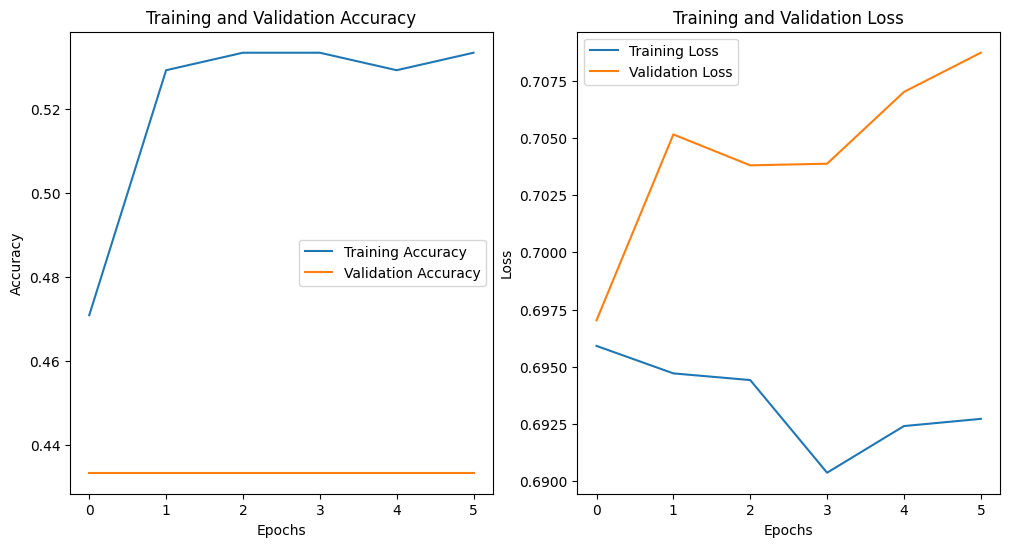

In [11]:
# Mengevaluasi performa model pada data validasi
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Menampilkan akurasi dalam bentuk angka
print(f'Accuracy: {accuracy * 100:.2f}%')

# Prediksi hasil dan menampilkan laporan klasifikasi
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))
# Plot grafik akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
# Cross-validation menggunakan KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kfold.split(padded_sequences):
    X_train_kfold, X_val_kfold = padded_sequences[train_idx], padded_sequences[val_idx]
    y_train_kfold, y_val_kfold = np.random.randint(2, size=len(X_train_kfold)), np.random.randint(2, size=len(X_val_kfold))
    
    history = model.fit(X_train_kfold, y_train_kfold, epochs=10, batch_size=32, validation_data=(X_val_kfold, y_val_kfold))
    scores = model.evaluate(X_val_kfold, y_val_kfold)
    cv_scores.append(scores[1])

print(f'Rata-rata akurasi dari cross-validation: {np.mean(cv_scores)}')

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4262 - loss: 0.6975 - val_accuracy: 0.4667 - val_loss: 0.6954
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4857 - loss: 0.6946 - val_accuracy: 0.4667 - val_loss: 0.6950
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5399 - loss: 0.6935 - val_accuracy: 0.5333 - val_loss: 0.6934
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5191 - loss: 0.6940 - val_accuracy: 0.5333 - val_loss: 0.6927
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5470 - loss: 0.6901 - val_accuracy: 0.5333 - val_loss: 0.6943
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5367 - loss: 0.6902 - val_accuracy: 0.5333 - val_loss: 0.6928
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5631 - loss: 0.6897 - val_accuracy: 0.5333 - val_loss: 0.6927
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5453 - loss: 0.6880 - val_accuracy: 0.5333 - val_loss: 0.6928


In [13]:
def retrieve_response(input_text):
    # Preprocess input text
    tokens = preprocess_text(input_text)
    sequence = tokenizer.texts_to_sequences([tokens])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    
    # Prediksi respons menggunakan model
    prediction = model.predict(padded_sequence)
    
    # Output respons terkait (sesuaikan sesuai task retrieval)
    return prediction


In [14]:
model.save('model_retrieval.h5')